# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

First, let's start by reviewing the data on the files

In [2]:
def get_info(dataset, name):
    print("Dataset info: " + name)
    print(dataset.info())
    print(dataset.head())

In [3]:
get_info(portfolio, "Portfolio Dataset")
get_info(profile, "Profile Dataset")
get_info(transcript, "Transcript Dataset")

Dataset info: Portfolio Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

      

# Data Cleaning #

**portfolio.json** needs to be cleaned before moving forward in order to better understand it.
Steps to be performed:
* Expand Channels
* Get dummies for Channels
* Get dummies for offer_type

Since there is only 9 values on Channels columns, it would be very easy just to pick the longest and create the dummies from there, but the idea is to create a solution that scales.

In [4]:
# Get unique channels by expanding the list within the columns.

In [5]:
unique_channel = portfolio['channels'].apply(pd.Series).stack().unique()

In [6]:
# Prepare Dummies for future analysis

In [7]:
dummies_df = pd.DataFrame(columns=unique_channel)
for channel in portfolio['channels']:
    row = {}
    for chan in unique_channel:
        if chan in channel:
            #print (chan + ": " + str(channel))
            row[chan] = 1
        else: row[chan] = 0
    dummies_df = dummies_df.append(row, ignore_index=True)

/tmp/ipykernel_9505/3589404038.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dummies_df = dummies_df.append(row, ignore_index=True)
/tmp/ipykernel_9505/3589404038.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dummies_df = dummies_df.append(row, ignore_index=True)
/tmp/ipykernel_9505/3589404038.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dummies_df = dummies_df.append(row, ignore_index=True)
/tmp/ipykernel_9505/3589404038.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dummies_df = dummies_df.append(row, ignore_index=True)
/tmp/ipykernel_9505/3589404038.py:9: FutureWarning: The frame.append method is deprecated an

In [8]:
portfolio_dummies = portfolio.join(dummies_df)

In [9]:
portfolio_dummies

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


With **portfolio.json** cleaned, let's move to review profile data

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


let's calculate the % of nulls to help decide how to deal with them

In [12]:
#based on above information will pick gender as the columns with nulls and Age for the columns with no nulls.
#To-Do Transform into function

perc = profile['gender'].isnull().sum()/profile['age'].count()
print ("The % of Nulls is: {:.0%}".format(perc))

The % of Nulls is: 13%


**13%** is to high for a plain deletion, will try to find a better way to fill those NA.

In [13]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

<AxesSubplot:xlabel='gender', ylabel='Count'>

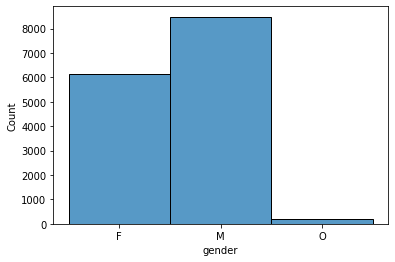

In [14]:
sns.histplot(data=profile, x="gender")

Considering the type of data on Gender, the best option would be to input the values based on the **Distribution** of the existing values

In [15]:
profile['gender'].value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [16]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
profile['gender_Fill'] = profile['gender'].fillna(pd.Series(np.random.choice(['M', 'F', 'O'], 
                                                      p=[0.572277, 0.413423, 0.014300], size=len(profile))))

In [18]:
profile['gender_Fill'].value_counts(normalize=True)

M    0.573353
F    0.412471
O    0.014176
Name: gender_Fill, dtype: float64

In [19]:
profile['gender_Fill'].value_counts()

M    9747
F    7012
O     241
Name: gender_Fill, dtype: int64

After that we have a new column with no NA and filled based on the distrubution.
For the Salary we will go for the **mean**.

<AxesSubplot:xlabel='income', ylabel='Count'>

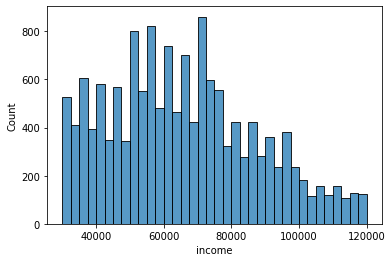

In [20]:
sns.histplot(data=profile, x="income")

In [21]:
profile['income_Fill'] = profile['income'].fillna(profile['income'].mean())

<AxesSubplot:xlabel='income', ylabel='Count'>

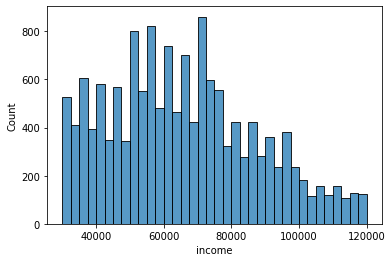

In [22]:
sns.histplot(data=profile, x="income")

In [23]:
print ("The old mean is {} and the new one is {}".format(profile['income'].mean(), profile['income_Fill'].mean()))

The old mean is 65404.9915682968 and the new one is 65404.9915682968


Both chart look similar enough and the means are the same since we use the mean as input method, so we can move 
forward

In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
 5   gender_Fill       17000 non-null  object 
 6   income_Fill       17000 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 929.8+ KB


## Transcript ##

Let's review Transcript dataset.

In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Good News is that there is no need to input missing data.

In [26]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


<AxesSubplot:xlabel='time', ylabel='Count'>

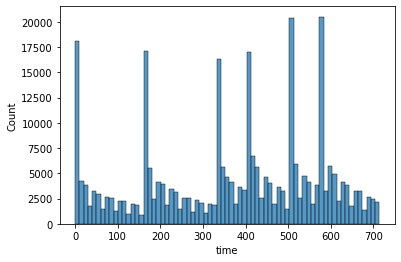

In [27]:
sns.histplot(data=transcript, x="time")

there's seems to be pattern where most interactions happens on specific times, let's dig depper into that.

<AxesSubplot:xlabel='time', ylabel='Count'>

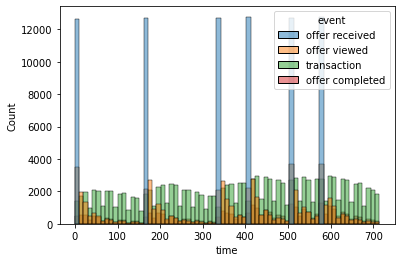

In [28]:
sns.histplot(data=transcript, x="time", hue="event")

So, couple of insights from the chart:
* transaction are spread evenly after the offer has been received.
* Views tend to fade quickly after offer has been received.
* Need futher review to analyze the completion
But before moving any further, let's clean the data to make it more manageable.

### Transcript Cleaning ###

Assumptions before cleaning:

* Offer time windows ends when new one starts (Event=offer received)
* All events within that timeframe can be allocated to the specific offer
* Offer may not complete.
* Offer may not be viewed but completed.


Tasks on cleaning:
* Order by Person and Time
* Assign Offer ID to all records within Offer time Window
* Expand values to new columns
* Flatten based on Person and Offer ID
    - Will need to sum based on Person and Offer ID
* Add count of transactions based on Person and Offer ID
* Add Flag for viewed
* Add Flag for completed

In [29]:
transcript_ordered = transcript.sort_values(by=['person', 'time'])

In [30]:
transcript_ordered.head()

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372


In [31]:
transcript_with_dummies = pd.concat([transcript_ordered,  transcript_ordered['value'].apply(pd.Series)], axis=1)

In [32]:
transcript_with_dummies.head()

,person,event,value,time,offer id,amount,offer_id,reward
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,NaN,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN


In [33]:
transcript_with_dummies.drop(['offer_id'], inplace = True, axis=1)
transcript_with_dummies['offer id'].fillna(method='ffill', inplace = True)

In [34]:
transcript_with_dummies.head()

,person,event,value,time,offer id,amount,reward
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,3f207df678b143eea3cee63160fa8bed,NaN,NaN


In [35]:
transcript_with_dummies[transcript_with_dummies['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,offer id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,5a8bc65990b245e5a138643cd4eb9837,19.67,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,5a8bc65990b245e5a138643cd4eb9837,29.72,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,5a8bc65990b245e5a138643cd4eb9837,23.93,NaN


In [36]:
transcript_wide = transcript_with_dummies.copy()

Get the number of transactions and keep it for later.

In [37]:
transcript_wide_transaction = transcript_wide.groupby(['person','offer id'])['event'].apply(lambda x: x[x == 'transaction'].count())

Same for the amount

In [38]:
transcript_wide_amount = transcript_wide.groupby(['person','offer id'])['amount'].sum()

Now, let's combine them into a single dataset.

In [39]:
transcript_wide_amount_transaction = pd.concat([transcript_wide_transaction, transcript_wide_amount], axis=1, join="inner")

In [40]:
transcript_wide_amount_transaction

event  \
person                           offer id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      4   
                                 3f207df678b143eea3cee63160fa8bed      0   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      2   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      6   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      5   
                                 2906b810c7d4411798c6938adc9daaa5      6   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      3   

                                                                   amount  
person                           offer id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5   69.20  
                                 3f207df678b143eea3cee63160fa8bed    0.00  
                                 5a8bc65990b245e5a138643cd4eb9837   22.16  
                                 f19421c1d4aa40978ebb69ca19b0e20d    8.57  
                                 fafdcd668e3743c1bb461111dcafc2a4   27.67  
...                                                                   ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d   46.77  
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7   96.37  
                                 2906b810c7d4411798c6938adc9daaa5   89.55  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9    7.79  
                                 fafdcd668e3743c1bb461111dcafc2a4   32.36  

[65028 rows x 2 columns]

Remove un-necessary columns Value and Time

In [54]:
transcript_wide = transcript_wide.drop(['value', 'time'], axis=1)

In [56]:
transcript_wide[transcript_wide['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,offer id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,5a8bc65990b245e5a138643cd4eb9837,19.67,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,5a8bc65990b245e5a138643cd4eb9837,29.72,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,5a8bc65990b245e5a138643cd4eb9837,23.93,NaN


Pivot event into columns with Flags

In [95]:
transcript_wide['flag'] = 1

In [96]:
transcript_wide_pivot = pd.pivot_table(transcript_wide, values='flag', index=['person', 'offer id'],
                    columns=['event'])
transcript_wide_pivot.fillna(0, inplace=True)

In [97]:
transcript_wide_pivot

event                                                              offer completed  \
person                           offer id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5              1.0   
                                 3f207df678b143eea3cee63160fa8bed              0.0   
                                 5a8bc65990b245e5a138643cd4eb9837              0.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d              1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              1.0   
...                                                                            ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d              1.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7              1.0   
                                 2906b810c7d4411798c6938adc9daaa5              1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9              1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4              1.0   

event                                                              offer received  \
person                           offer id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             1.0   
                                 3f207df678b143eea3cee63160fa8bed             1.0   
                                 5a8bc65990b245e5a138643cd4eb9837             1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             1.0   
...                                                                           ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d             1.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7             1.0   
                                 2906b810c7d4411798c6938adc9daaa5             1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4             1.0   

event                                                              offer viewed  \
person                           offer id                                         
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5           0.0   
                                 3f207df678b143eea3cee63160fa8bed           1.0   
                                 5a8bc65990b245e5a138643cd4eb9837           1.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d           1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4           1.0   
...                                                                         ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d           1.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7           1.0   
                                 2906b810c7d4411798c6938adc9daaa5           1.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9           1.0   
                                 fafdcd668e3743c1bb461111dcafc2a4           1.0   

event                                                              transaction  
person                           offer id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5          1.0  
                                 3f207df678b143eea3cee63160fa8bed          0.0  
                                 5a8bc65990b245e5a138643cd4eb9837          1.0  
                                 f19421c1d4aa40978ebb69ca19b0e20d          1.0  
                                 fafdcd668e3743c1bb461111dcafc2a4          1.0  
...                                                                        ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40

Combine into single dataset

In [98]:
transcript_combined = pd.concat([transcript_wide_amount_transaction, transcript_wide_pivot], axis=1, join="inner")

Pending data:
* [x] Type of offer
* [x] Reward
* [x] difficulty
* [x] Channels
* [x] Duration

In [99]:
transcript_portfolio = transcript_combined.reset_index().merge(portfolio_dummies, left_on='offer id', right_on='id')

In [100]:
transcript_portfolio.drop(["id", "channels"], axis=1, inplace=True)

In [102]:
transcript_portfolio.sort_values(by=['person'])

,person,offer id,event,amount,offer completed,offer received,offer viewed,transaction,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,4,69.20,1.0,1.0,0.0,1.0,2,10,7,discount,1,1,0,1
12965,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,22.16,0.0,1.0,1.0,1.0,0,0,3,informational,1,1,1,0
19457,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,8.57,1.0,1.0,1.0,1.0,5,5,5,bogo,1,1,1,1
25899,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2,27.67,1.0,1.0,1.0,1.0,2,10,10,discount,1,1,1,1
6456,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,0.00,0.0,1.0,1.0,0.0,0,0,4,informational,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51985,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,18.04,1.0,1.0,1.0,1.0,5,5,7,bogo,1,1,0,1
51986,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,7.79,1.0,1.0,1.0,1.0,5,5,7,bogo,1,1,0,1
32401,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,3,32.36,1.0,1.0,1.0,1.0,2,10,10,discount,1,1,1,1
6455,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,6,89.55,1.0,1.0,1.0,1.0,2,10,7,discount,1,1,0,1


In [103]:
transcript_portofolio_profile = transcript_portfolio.merge(profile, left_on='person', right_on='id')

In [105]:
transcript_portofolio_profile.drop(['gender', 'income', 'id'], axis = 1, inplace=True)

In [106]:
transcript_portofolio_profile

,person,offer id,event,amount,offer completed,offer received,offer viewed,transaction,reward,difficulty,duration,offer_type,email,mobile,social,web,age,became_member_on,gender_Fill,income_Fill
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,4,69.20,1.0,1.0,0.0,1.0,2,10,7,discount,1,1,0,1,33,20170421,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,0.00,0.0,1.0,1.0,0.0,0,0,4,informational,1,1,0,1,33,20170421,M,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,22.16,0.0,1.0,1.0,1.0,0,0,3,informational,1,1,1,0,33,20170421,M,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,8.57,1.0,1.0,1.0,1.0,5,5,5,bogo,1,1,1,1,33,20170421,M,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2,27.67,1.0,1.0,1.0,1.0,2,10,10,discount,1,1,1,1,33,20170421,M,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65023,47683732768a4f7db7abb710ca22e66e,ae264e3637204a6fb9bb56bc8210ddfd,1,7.10,0.0,1.0,1.0,1.0,10,10,7,bogo,1,1,1,0,24,20171108,M,56000.0
65024,5f99f2a855484c3884f043c592d96447,ae264e3637204a6fb9bb56bc8210ddfd,10,39.21,1.0,1.0,1.0,1.0,10,10,7,bogo,1,1,1,0,77,20171008,M,53000.0
65025,930305f046fa4f218d2539fb99baefb9,ae264e3637204a6fb9bb56bc8210ddfd,17,44.32,0.0,1.0,1.0,1.0,10,10,7,bogo,1,1,1,0,68,20131215,M,38000.0
65026,948ec827ac334c8782a1da99a2d6a39b,ae264e3637204a6fb9bb56bc8210ddfd,16,182.39,1.0,1.0,1.0,1.0,10,10,7,bogo,1,1,1,0,61,20160108,M,44000.0


## What is next ##

Next steps to complete:

* [X] Analyze compiled dataset
    - [X] Create charts for:
        - is a profile more prone to view/complete offer?
        - what are the most succesful offer by profile? - Viewed offer and completed
        - Drill down charts
    - [X] general population description
* [X] Heuristic approach to define who should receive
* [] ML model

Now,let's proceed to the analysis of cleaned dataset, firts let's describe the general population in **profile.json**

In [113]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'gender_Fill',
       'income_Fill'],
      dtype='object')

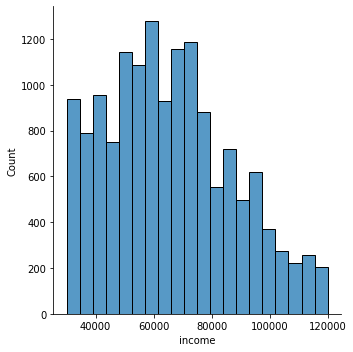

In [117]:
sns.displot(profile, x="income", bins=20)

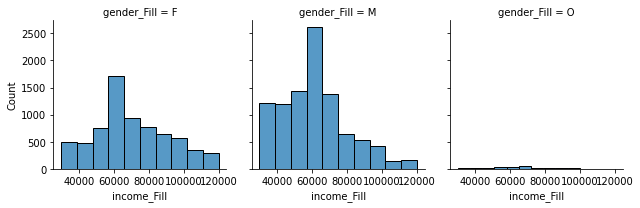

In [124]:
g = sns.FacetGrid(profile, col="gender_Fill")
g.map(sns.histplot, "income_Fill", bins=10)

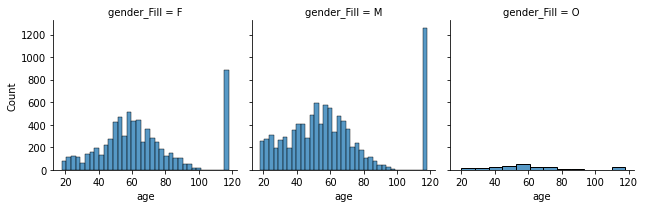

In [122]:
g = sns.FacetGrid(profile, col="gender_Fill")
g.map(sns.histplot, "age")

Full analysis on the data

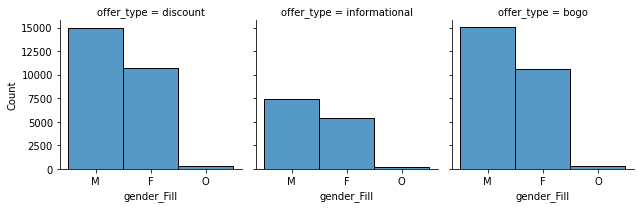

In [125]:
g = sns.FacetGrid(transcript_portofolio_profile, col="offer_type")
g.map(sns.histplot, "gender_Fill")

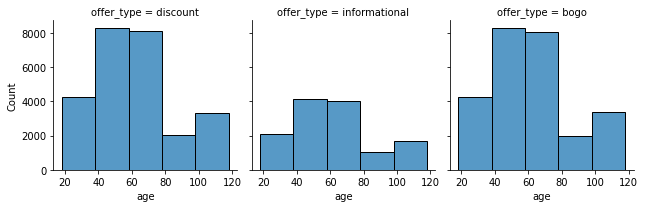

In [128]:
g = sns.FacetGrid(transcript_portofolio_profile, col="offer_type")
g.map(sns.histplot, "age", bins=5)

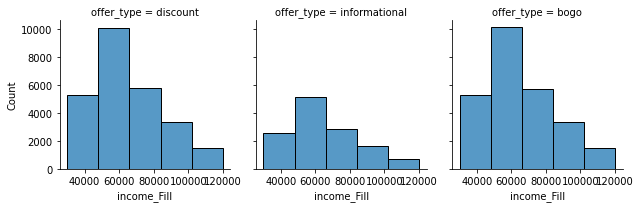

In [129]:
g = sns.FacetGrid(transcript_portofolio_profile, col="offer_type")
g.map(sns.histplot, "income_Fill", bins=5)

In [135]:
summary = transcript_portofolio_profile.groupby(['offer_type','age', 'gender_Fill'])['offer completed', 'offer viewed', 'offer received'].sum()

/tmp/ipykernel_9505/188230404.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary = transcript_portofolio_profile.groupby(['offer_type','age', 'gender_Fill'])['offer completed', 'offer viewed', 'offer received'].sum()


Since is  not likely we have as many people above 100 years buying, we will treat it as an outlier and remove it from the dataset.

In [144]:
summary = summary.reset_index()
summary_filtered= summary[summary['age'] <= 100]

<AxesSubplot:xlabel='age', ylabel='offer received'>

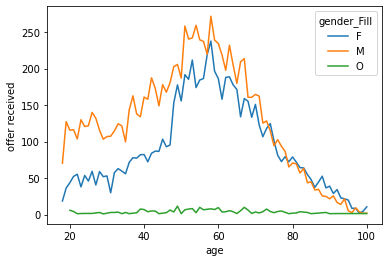

In [152]:
sns.lineplot(data=summary_filtered, x="age", y="offer received", hue="gender_Fill", ci=None)

<AxesSubplot:xlabel='age', ylabel='offer viewed'>

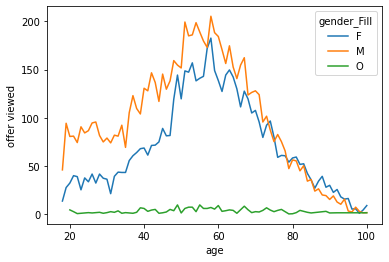

In [151]:
sns.lineplot(data=summary_filtered, x="age", y="offer viewed", hue="gender_Fill", ci=None)

<AxesSubplot:xlabel='age', ylabel='offer completed'>

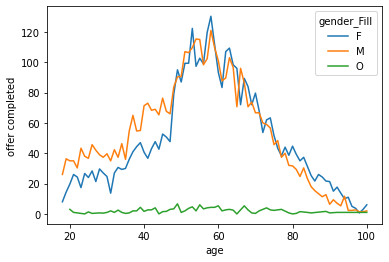

In [153]:
sns.lineplot(data=summary_filtered, x="age", y="offer completed", hue="gender_Fill", ci=None)

Let's investigate what offers are not beign opened and completed

In [177]:
summary_filtered_viewed  = summary_filtered[(summary_filtered['offer viewed'] == 1) & 
                                               (summary_filtered['offer completed'] == 1)]

In [181]:
summary_filtered_viewed

,offer_type,age,gender_Fill,offer completed,offer viewed,offer received
12,bogo,22,O,1.0,1.0,1.0
31,bogo,29,O,1.0,1.0,1.0
46,bogo,34,O,1.0,1.0,1.0
79,bogo,45,O,1.0,1.0,1.0
154,bogo,70,O,1.0,1.0,2.0
195,bogo,85,O,1.0,1.0,1.0
223,bogo,98,F,1.0,1.0,1.0
257,discount,26,O,1.0,1.0,1.0
276,discount,33,O,1.0,1.0,1.0
285,discount,36,O,1.0,1.0,1.0


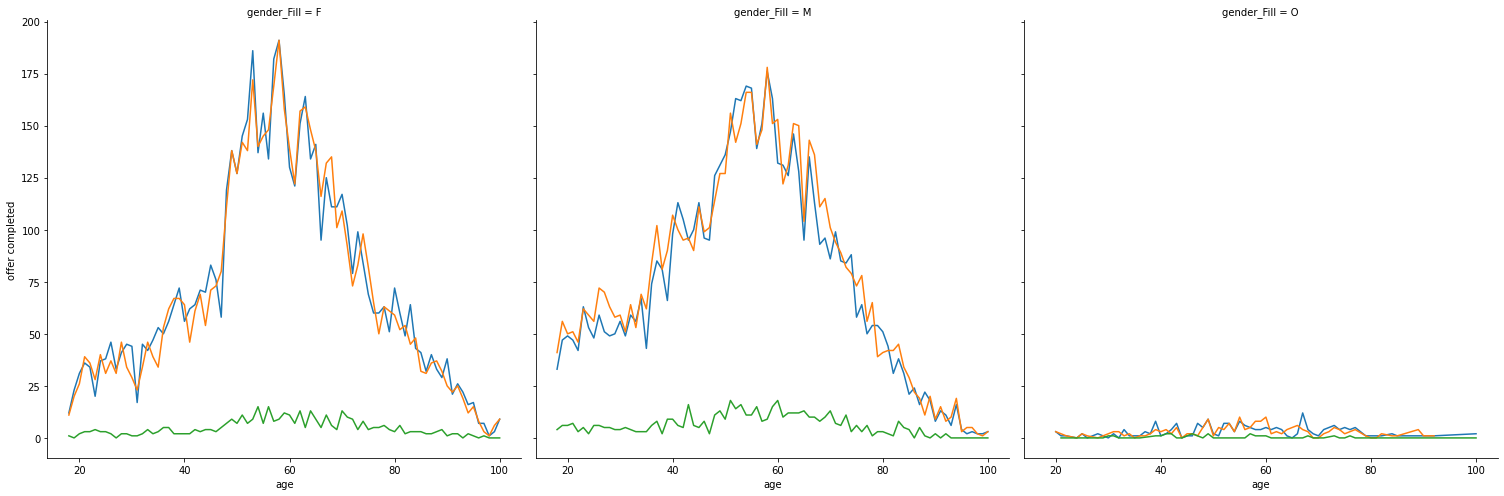

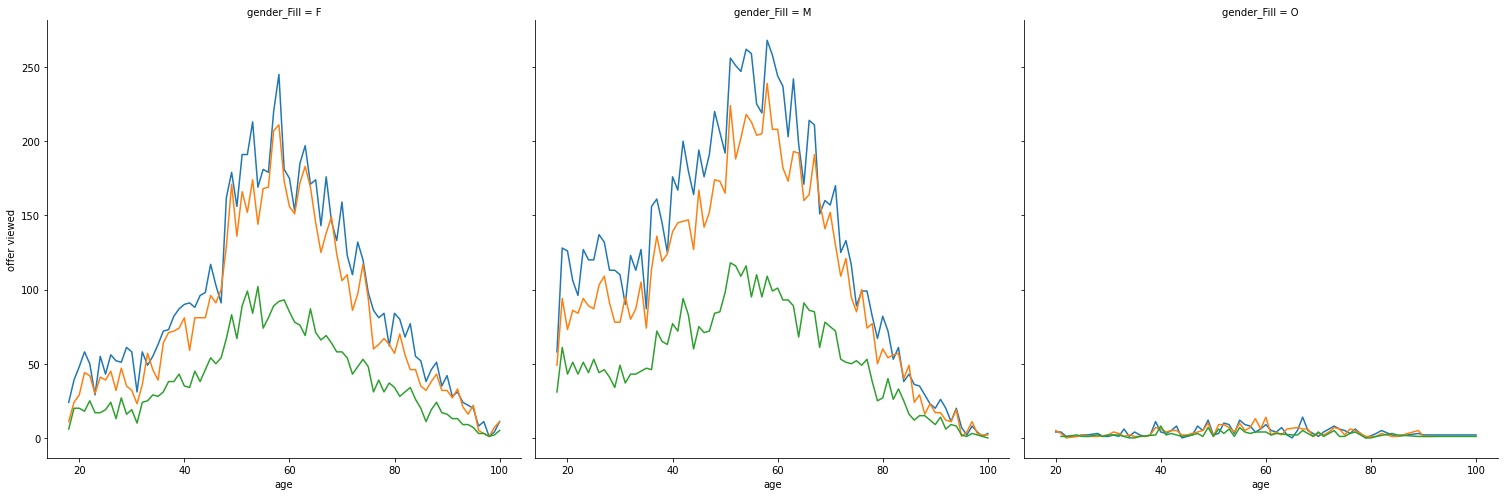

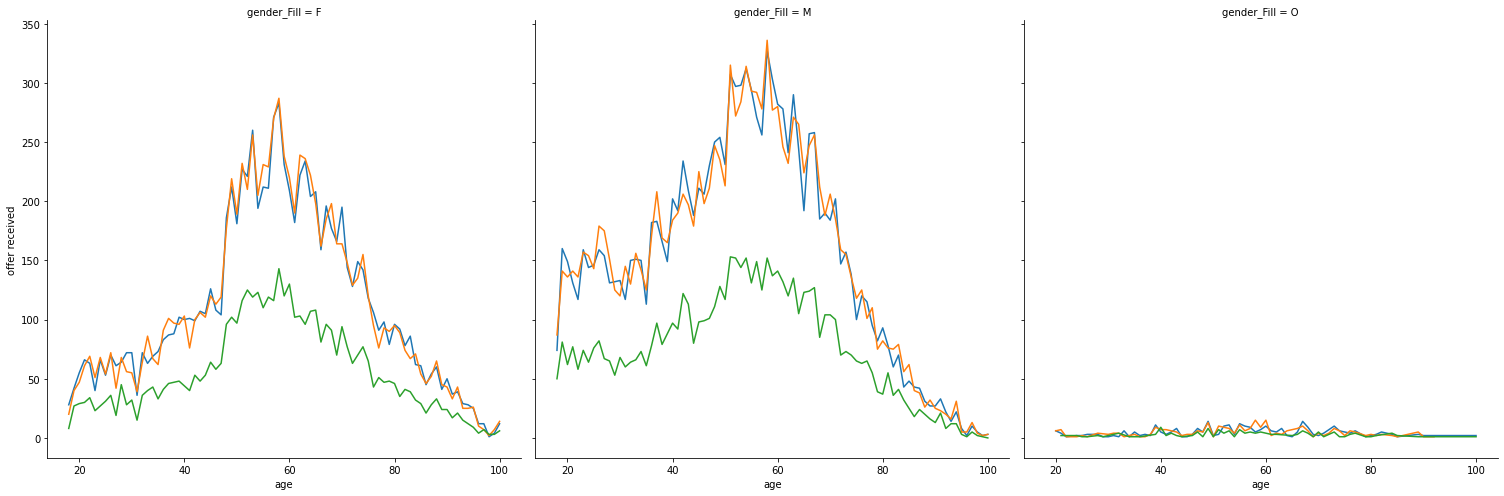

In [192]:
cols = ['offer completed' , 'offer viewed', 'offer received']
for column in cols:
    g = sns.FacetGrid(summary_filtered, col='gender_Fill' , hue="offer_type", height=7)
    g.map(sns.lineplot, "age", column, ci=None) 

To-Do
* Make bins for age
* make bins for income

## ML Model ##

* [] create dummies
    * [] offer_type
    * [] gender_Fill
* [] Split dataset
* [] Train models
* [] look for the best model

In [193]:
transcript_portofolio_profile.columns

Index(['person', 'offer id', 'event', 'amount', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'reward', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'age',
       'became_member_on', 'gender_Fill', 'income_Fill'],
      dtype='object')

In [208]:
#gender dummy
gender = pd.get_dummies(transcript_portofolio_profile['gender_Fill'],prefix = "gender", prefix_sep = "-")
transcript_portofolio_profile = pd.concat([transcript_portofolio_profile,gender],axis=1)

#offer_type dummy
offer_type = pd.get_dummies(transcript_portofolio_profile['offer_type'],prefix = "offer_type", prefix_sep = "-")
transcript_portofolio_profile = pd.concat([transcript_portofolio_profile,offer_type],axis=1)


transcript_portofolio_profile_ml = transcript_portofolio_profile.drop(['person', 'offer id', 'offer_type', 'gender_Fill'], axis=1)

In [209]:
X = transcript_portofolio_profile_ml.drop('offer completed', axis = 1)
Y = transcript_portofolio_profile_ml['offer completed']

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [210]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      9585
         1.0       0.94      0.93      0.94      6672

    accuracy                           0.95     16257
   macro avg       0.95      0.94      0.95     16257
weighted avg       0.95      0.95      0.95     16257

0.9352355072463768


0.9472227348219229

In [211]:
#Adaboost with Logistics regression data : model1_df
abc =AdaBoostClassifier(n_estimators=100, learning_rate=1)
abc.fit(X_train,Y_train)
y_pred = abc.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      9585
         1.0       0.88      0.93      0.91      6672

    accuracy                           0.92     16257
   macro avg       0.92      0.92      0.92     16257
weighted avg       0.92      0.92      0.92     16257

0.9072451066316097


0.9218798056221935

# DONE #

In [212]:
lrparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

LR_search = GridSearchCV(lr, param_grid=lrparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(X_train_scale,Y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

NameError: name 'lr' is not defined

In [ ]:
clf = RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=15, min_samples_split=25,
                             n_estimators=100,random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(clf, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))